In [1]:
# most stuff in this nb will be moved to either config or hospital_model.
from config import CONFIG_mkB
from hospital_model import create_hospital_simulation
import numpy as np
import simpy


In [2]:
env = simpy.Environment()

conf = CONFIG_mkB.copy() # prevent side effect on default configuration
conf['seed'] = 2025
results = create_hospital_simulation(env,conf)
env.run(until=2000)
print(results['util_active'][1] / results['total_active'][1]) # op room utilization %
# (note /0 error if sim time is too short to have any events. this is fine.)
print(results['patient_flow'][0]) # first patient entire treatment timeline
print(results['patient_counts'])
print(results['snapshots'][-1]['patient_counts'])

# simulate changing hospital flow.
# note that this can also take into account the current simulation state.
# for demonstration this just makes a visible change by reducing amount of new patients entering the system
conf['means'] = [100, 40, 20, 40]
env.run(until=env.now + 2000)
print(results['snapshots'][-1])

0.933724774503474
[0, 0, 51.90383750379573, 64.89050943476566, 72.50230606603436]
[3, 2, 1, 0]
[3, 3, 0, 0]
{'time': 3980, 'patient_counts': [0, 0, 0, 0]}


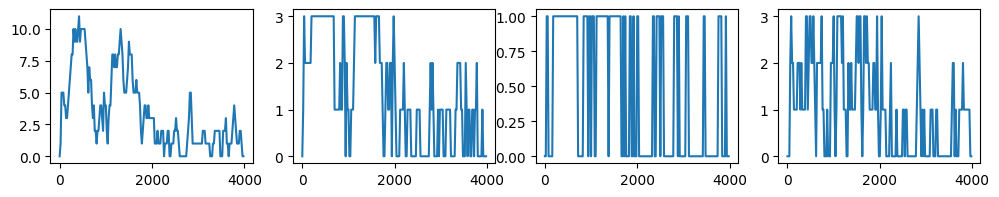

In [3]:
# visualize rooms:
import matplotlib.pyplot as plt

plot_stages = len(results['snapshots'][0]['patient_counts']) # plot each metric monitored by snapshots
fig, axs = plt.subplots(figsize=(3*plot_stages,2),ncols = plot_stages)
x = [s['time'] for s in results['snapshots']] # snapshot times on x-axis
for a in range(len(axs)):
    axs[a].plot(x,[s['patient_counts'][a] for s in results['snapshots']])

In [14]:
#
reso = simpy.Resource(env,capacity=conf['rooms'][0])
a = reso.request()
print(reso)